In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import mean_squared_error

# 检查是否有GPU可用
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# 读取CSV文件
file_path = 'cleaned_D.csv'
combined_data = pd.read_csv(file_path)

# 确保列名正确
print(combined_data.columns)

# 数据标准化
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(combined_data[['position-y', 'position-z']])

# 准备训练数据
def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset) - look_back - 1):
        a = dataset[i:(i + look_back), :]
        X.append(a)
        Y.append(dataset[i + look_back, :])
    return np.array(X), np.array(Y)

look_back = 30  # 可以根据需求调整
X, Y = create_dataset(data_scaled, look_back)

# 将数据划分为训练集和测试集
train_size = int(len(X) * 0.67)
test_size = len(X) - train_size
trainX, testX = X[0:train_size], X[train_size:len(X)]
trainY, testY = Y[0:train_size], Y[train_size:len(Y)]

# 将数据转换为PyTorch张量并移到设备上
trainX = torch.tensor(trainX, dtype=torch.float32).to(device)
trainY = torch.tensor(trainY, dtype=torch.float32).to(device)
testX = torch.tensor(testX, dtype=torch.float32).to(device)
testY = torch.tensor(testY, dtype=torch.float32).to(device)

# 打印前几行以验证
print(combined_data.head())

Using device: cuda
Index(['timestamp', 'position-y', 'position-z'], dtype='object')
      timestamp  position-y  position-z
0  1.721643e+09   -0.001515    0.315035
1  1.721643e+09   -0.001505    0.315014
2  1.721643e+09   -0.001513    0.315025
3  1.721643e+09   -0.001507    0.315049
4  1.721643e+09   -0.001511    0.315045


In [7]:
import tqdm
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_layer_size, output_size):
        super(LSTM, self).__init__()
        self.hidden_layer_size = hidden_layer_size
        self.lstm = nn.LSTM(input_size, hidden_layer_size, batch_first=True)
        self.linear = nn.Linear(hidden_layer_size, output_size)
        self.hidden_cell = (torch.zeros(1, 1, self.hidden_layer_size).to(device),
                            torch.zeros(1, 1, self.hidden_layer_size).to(device))

    def forward(self, input_seq):
        lstm_out, self.hidden_cell = self.lstm(input_seq, self.hidden_cell)
        predictions = self.linear(lstm_out[:, -1])
        return predictions

# 定义模型参数
input_size = 2
hidden_layer_size = 50
output_size = 2

# 初始化模型、损失函数和优化器
model = LSTM(input_size, hidden_layer_size, output_size).to(device)
loss_function = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 训练模型
epochs = 30
batch_size = 16  # 根据显存大小调整
train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(trainX, trainY), batch_size=batch_size, shuffle=True)

for epoch in tqdm.trange(epochs):
    model.train()
    for seq, label in train_loader:
        optimizer.zero_grad()
        model.hidden_cell = (torch.zeros(1, seq.size(0), model.hidden_layer_size).to(device),
                             torch.zeros(1, seq.size(0), model.hidden_layer_size).to(device))

        y_pred = model(seq)

        single_loss = loss_function(y_pred, label)
        single_loss.backward()
        optimizer.step()

    if epoch % 10 == 0:
        print(f'Epoch {epoch} loss: {single_loss.item()}')

print(f'Epoch {epochs} loss: {single_loss.item()}')

  3%|▎         | 1/30 [00:05<02:43,  5.65s/it]

Epoch 0 loss: 1.181904099212261e-05


 37%|███▋      | 11/30 [01:04<01:52,  5.90s/it]

Epoch 10 loss: 5.164452431927202e-06


 70%|███████   | 21/30 [02:00<00:49,  5.49s/it]

Epoch 20 loss: 2.0254094579286175e-06


100%|██████████| 30/30 [02:50<00:00,  5.67s/it]

Epoch 30 loss: 2.9064253794786055e-06


['DataSet/D/ee_20240722111110.csv', 'DataSet/D/ee_20240722111909.csv', 'DataSet/D/ee_20240722110925.csv', 'DataSet/D/ee_20240722111846.csv']


ValueError: could not broadcast input array from shape (375,2) into shape (365,2)

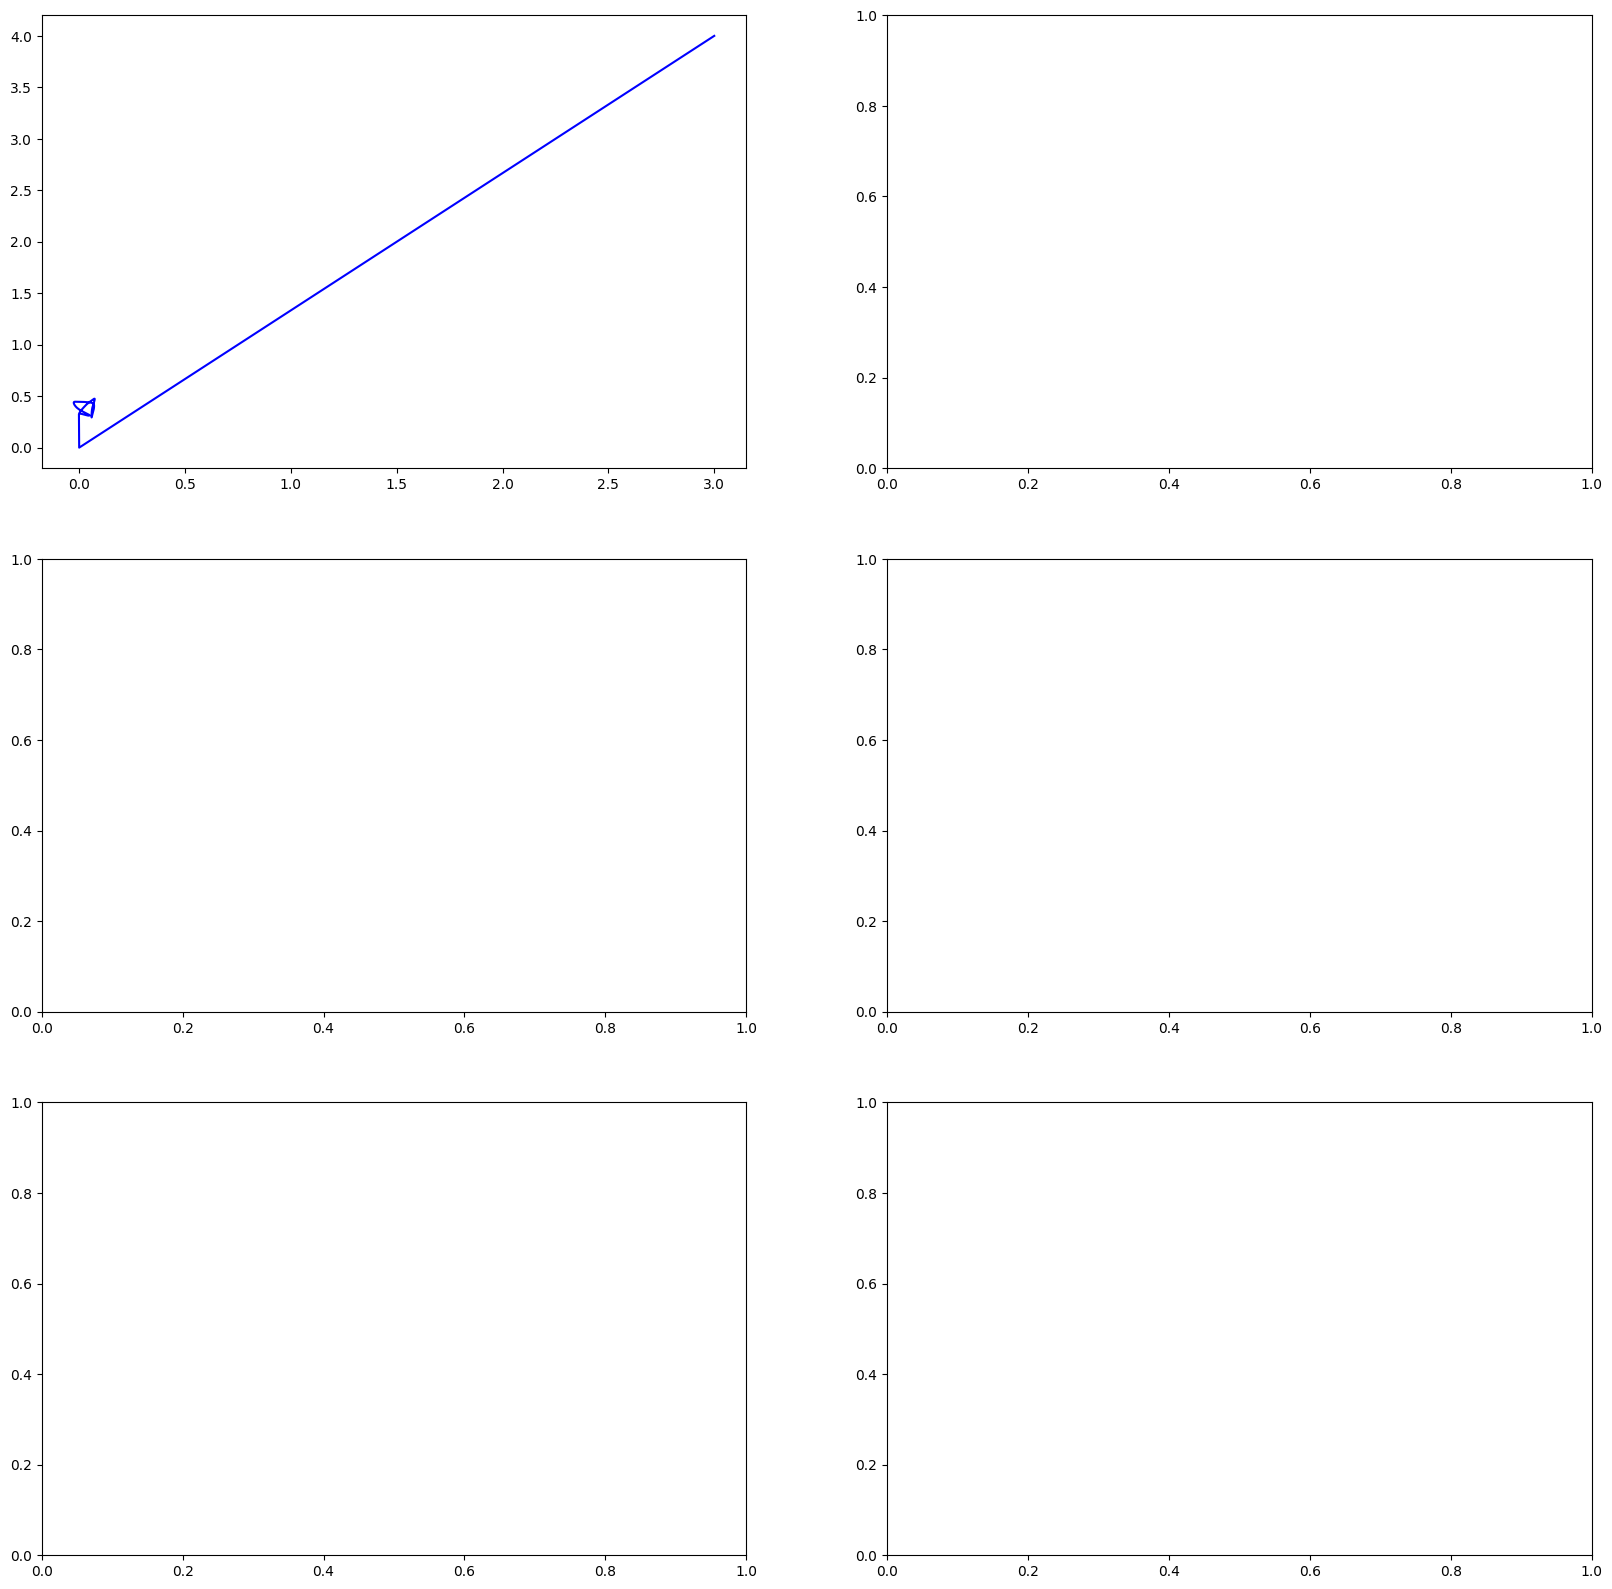

In [16]:
import glob
import os
import random
# 定义文件目录和获取所有以 ee 开头的 CSV 文件
directory_path = 'DataSet/D/'
all_files = glob.glob(os.path.join(directory_path, "ee*.csv"))

# 随机抽取5个CSV文件
selected_files = random.sample(all_files, 4)
print(selected_files)

def process_file(file, model, device):
    # 读取CSV文件
    data_frame = pd.read_csv(file, header=None, usecols=[4, 5], names=['position-y', 'position-z'])

    # 数据标准化
    scaler = MinMaxScaler(feature_range=(0, 1))
    data_scaled = scaler.fit_transform(data_frame)

    # 准备训练数据和测试数据
    train_size = len(data_scaled) // 2
    train_data = data_scaled[:train_size]
    test_data = data_scaled[train_size:]

    # 创建训练数据集和测试数据集
    def create_dataset(dataset, look_back=1):
        X, Y = [], []
        for i in range(len(dataset) - look_back):
            a = dataset[i:(i + look_back), :]
            X.append(a)
            Y.append(dataset[i + look_back, :])
        return np.array(X), np.array(Y)

    look_back = 10  # 可以根据需求调整
    trainX, trainY = create_dataset(train_data, look_back)
    testX, testY = create_dataset(test_data, look_back)

    # 将数据转换为PyTorch张量并移到设备上
    trainX = torch.tensor(trainX, dtype=torch.float32).to(device)
    trainY = torch.tensor(trainY, dtype=torch.float32).to(device)
    testX = torch.tensor(testX, dtype=torch.float32).to(device)
    testY = torch.tensor(testY, dtype=torch.float32).to(device)

    # 使用训练好的模型进行预测
    train_predict = []
    test_predict = []

    with torch.no_grad():
        for i in range(len(trainX)):
            seq = trainX[i:i+1]
            model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size).to(device),
                                 torch.zeros(1, 1, model.hidden_layer_size).to(device))
            train_predict.append(model(seq).cpu().numpy())

        for i in range(len(testX)):
            seq = testX[i:i+1]
            model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size).to(device),
                                 torch.zeros(1, 1, model.hidden_layer_size).to(device))
            test_predict.append(model(seq).cpu().numpy())

    train_predict = scaler.inverse_transform(np.array(train_predict).reshape(-1, 2))
    trainY = scaler.inverse_transform(trainY.cpu())
    test_predict = scaler.inverse_transform(np.array(test_predict).reshape(-1, 2))
    testY = scaler.inverse_transform(testY.cpu())

    return train_predict, trainY, test_predict, testY, data_frame

# 创建子图
fig, axs = plt.subplots(3, 2, figsize=(20, 20))
axs = axs.flatten()

# 处理每个文件并绘制结果
for idx, file in enumerate(selected_files):
    train_predict, trainY, test_predict, testY, data_frame = process_file(file, model, device)

    # 绘制结果
    ax = axs[idx]
    
    # 实际轨迹
    ax.plot(data_frame['position-y'], data_frame['position-z'], label='Actual Trajectory', color='blue')

    # 训练集预测轨迹
    train_predict_len = len(train_predict)
    test_predict_len = len(test_predict)
    
    trainPredictPlot = np.empty((len(data_frame), 2))
    trainPredictPlot[:, :] = np.nan
    trainPredictPlot[look_back:look_back+train_predict_len, :] = train_predict

    # 测试集预测轨迹
    testPredictPlot = np.empty((len(data_frame), 2))
    testPredictPlot[:, :] = np.nan
    testPredictPlot[look_back+train_predict_len:look_back+train_predict_len+test_predict_len, :] = test_predict

    # 绘制训练集预测
    ax.plot(trainPredictPlot[:, 0], trainPredictPlot[:, 1], label='Train Predict Trajectory', color='red')

    # 绘制测试集预测
    ax.plot(testPredictPlot[:, 0], testPredictPlot[:, 1], label='Test Predict Trajectory', color='green')

    # 设置图例和标题
    ax.legend()
    ax.set_title(f'Trajectory Prediction for File {idx+1}')
    ax.set_xlabel('Position-Y')
    ax.set_ylabel('Position-Z')

    # ax.set_ylim(0, 1)
    # ax.set_xlim(-1, 0.3)

# 隐藏多余的子图
for j in range(idx+1, len(axs)):
    fig.delaxes(axs[j])

# 显示图像
plt.tight_layout()
plt.show()